# Actividad Deep Vision

**Nombre del grupo:** GRUPO 8

**Integrantes:**
- Ricardo Castillo
- Miriam
- Katherine

---

## 📌 Objetivo del proyecto

Comparar dos estrategias de clasificación de imágenes en el dataset CIFAR100: (1) Transfer learning con redes preentrenadas, y (2) Entrenamiento de una red desde cero.

## 🔢 Carga y visualización de datos
Cargamos el dataset CIFAR100 y visualizamos algunas imágenes para familiarizarnos con los datos.

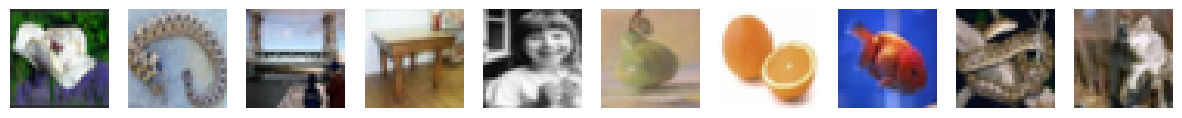

In [3]:
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Mostrar 10 imágenes aleatorias
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    idx = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[idx])
    axes[i].axis('off')
plt.show()

## 🔹 Estrategia 1: Transfer Learning + Fine-Tuning

### 📦 Preparación de los datos
Redimensionamiento, normalización y creación de generadores de datos.

### 🔍 Comparación de arquitecturas preentrenadas
Probaremos al menos dos modelos como ResNet50 y MobileNetV2.

### ResNet50

#### Preprocesamiento de datos para ResNet50

In [ ]:
# Preprocesamiento eficiente con tf.data.Dataset
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

# Función para redimensionar y preprocesar cada imagen
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))     # Resize a 224x224
    image = preprocess_input(image)                          # Preprocesado específico de ResNet50
    return image, label

# Dataset de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Dataset de validación/test
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


#### ResNet50 pre fine-tunning (modelo base)

##### Modelaje y explicación del modelo

In [ ]:
# Importamos componentes clave para construir el modelo
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargamos la arquitectura base ResNet50 sin su parte superior (clasificación de ImageNet)
base_model = ResNet50(
    weights='imagenet',               # Usamos pesos preentrenados en ImageNet
    include_top=False,                # Quitamos las capas de clasificación final
    input_tensor=Input(shape=(224, 224, 3))  # Entrada esperada por ResNet50
)

# Congelamos las capas del modelo base para que no se entrenen aún
base_model.trainable = False

# Construimos la "cabeza" del modelo adaptada a CIFAR100
x = base_model.output                           # Salida del modelo base
x = GlobalAveragePooling2D()(x)                 # Convierte los mapas de activación en un vector
x = Dense(256, activation='relu')(x)            # Capa densa intermedia
x = Dropout(0.5)(x)                              # Dropout para regularización
output = Dense(100, activation='softmax')(x)    # Capa de salida con 100 neuronas (una por clase)

# Creamos el modelo final combinando base y top
modelo = Model(inputs=base_model.input, outputs=output)

# Compilamos el modelo indicando optimizador, función de pérdida y métricas
modelo.compile(
    optimizer=Adam(learning_rate=0.001),             # Optimizador Adam
    loss='sparse_categorical_crossentropy',          # Para etiquetas enteras (no one-hot)
    metrics=['accuracy']                             # Métrica de evaluación
)

# Mostramos el resumen del modelo
modelo.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,137,956 (92.08 MB)

 Trainable params: 550,244 (2.10 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 **🧾 Resumen del modelo (explicación)**

El modelo está compuesto por **ResNet50 como base (sin su top)** y un **top model personalizado**.
Se están usando pesos **preentrenados en ImageNet**, y todas las capas de ResNet50 están **congeladas**, es decir, **no se reentrenan en esta fase**.

El top model incluye:
- Una capa de **GlobalAveragePooling2D** que reduce la dimensión del output de ResNet50.
- Una capa **Dense (256, ReLU)** que actúa como clasificador intermedio.
- Un **Dropout del 50%** para evitar sobreajuste.
- Una capa **Dense final de 100 neuronas con softmax**, correspondiente a las 100 clases de CIFAR100.

 **📊 Parámetros del modelo:**
- **Total de parámetros**: `24,137,956`  
  Es la suma de todos los pesos del modelo completo (base + top).
- **Parámetros entrenables**: `550,244`  
  Solo corresponden al top model, que es la parte que estamos entrenando ahora.
- **Parámetros no entrenables**: `23,587,712`  
  Son los pesos de la ResNet50, que están congelados y **no se actualizan** durante esta fase.

✅ En esta fase solo estamos enseñando a la “cabeza” del modelo cómo clasificar imágenes de CIFAR100 usando lo que ResNet ya sabe.


##### Entrenamiento de la primera fase (solo top model)

In [ ]:
# Callback para parar el entrenamiento si no mejora en 5 épocas seguidas
early_stop = EarlyStopping(
    patience=5,                     # Número de épocas sin mejora antes de parar
    restore_best_weights=True      # Vuelve a los pesos con mejor validación
)

# Callback para reducir el learning rate si no mejora en 3 épocas
reduce_lr = ReduceLROnPlateau(
    patience=3,                    # Épocas sin mejora antes de reducir el LR
    factor=0.5,                    # Reduce el LR a la mitad
    verbose=1                      # Muestra mensaje cuando se reduzca el LR
)

# Entrenamiento del modelo (solo el top model, ResNet50 congelado)
history = modelo.fit(
    train_dataset,                 # Dataset de entrenamiento procesado con tf.data
    epochs=20,                     # Número máximo de épocas
    validation_data=test_dataset,  # Validación sobre el set de test
    callbacks=[early_stop, reduce_lr]  # Callbacks para optimización del entrenamiento
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 184s 108ms/step - accuracy: 0.3272 - loss: 2.7795 - val_accuracy: 0.6393 - val_loss: 1.2536 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 184s 102ms/step - accuracy: 0.5456 - loss: 1.6209 - val_accuracy: 0.6608 - val_loss: 1.1557 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 201s 101ms/step - accuracy: 0.5821 - loss: 1.4660 - val_accuracy: 0.6704 - val_loss: 1.1255 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 101ms/step - accuracy: 0.6001 - loss: 1.3838 - val_accuracy: 0.6795 - val_loss: 1.1024 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 101ms/step - accuracy: 0.6180 - loss: 1.3119 - val_accuracy: 0.6777 - val_loss: 1.1025 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 101ms/step - accuracy: 0.6338 - loss: 1.2554 - val_accuracy: 0.6858 - val_loss: 1.0825 - learning_rate: 0.0010
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 217s 111ms/step - acc

##### Visualización de resultados

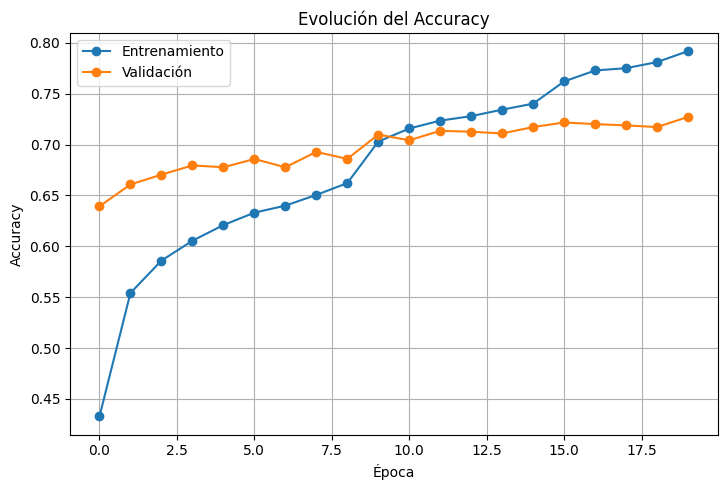

In [ ]:
# 📊 Visualización de métricas de entrenamiento
import matplotlib.pyplot as plt

# Ajustamos el tamaño de las figuras
plt.figure(figsize=(14, 5))

# --- Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', marker='o')
plt.plot(history.history['val_accuracy'], label='Validación', marker='o')
plt.title('Evolución del Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**📈 Gráfica 1: Evolución del Accuracy**

**🔵 Línea azul (Entrenamiento):**

- Comienza baja (~43%) y sube de forma estable hasta ~79%. Esto indica que el modelo aprende progresivamente sin estancarse.

- No hay saltos bruscos, ni picos raros, por lo que el aprendizaje es suave y constante.

**🟠 Línea naranja (Validación):**

- Empieza fuerte (~64%) y sube hasta estabilizarse en torno al 72–73%.

- Al principio, el val_accuracy es mayor que el de entrenamiento, lo que es típico cuando el modelo aún no ha memorizado bien.

- Luego se estabiliza, lo cual es buena señal: no hay sobreajuste evidente.

**✅ Conclusión Accuracy:**

Modelo bien entrenado, sin señales de overfitting. Hemos exprimido bien la cabeza (top model) del ResNet50.

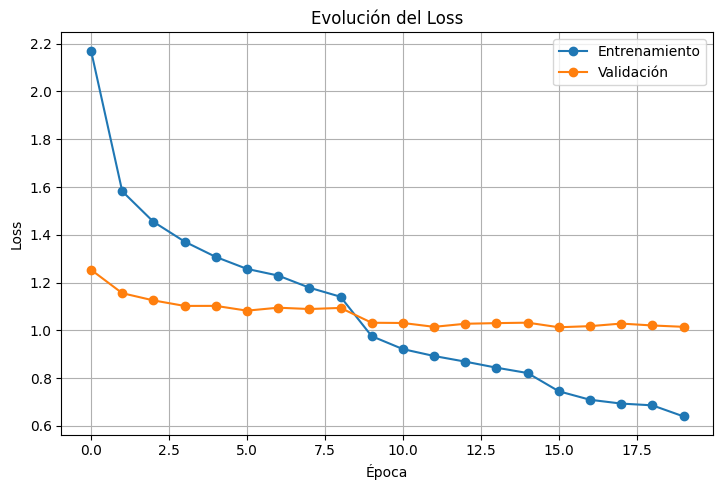

In [ ]:
# 📊 Visualización de métricas de entrenamiento
import matplotlib.pyplot as plt

# Ajustamos el tamaño de las figuras
plt.figure(figsize=(14, 5))

# --- Loss ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', marker='o')
plt.plot(history.history['val_loss'], label='Validación', marker='o')
plt.title('Evolución del Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**📉 Gráfica 2: Evolución del Loss**

**🔵 Línea azul (Entrenamiento):**

- Baja con fuerza de ~2.2 a ~0.65. Esto indica que el modelo reduce errores internos progresivamente.

- Curva suave, sin rebotes, lo que muestra aprendizaje sano.

**🟠 Línea naranja (Validación):**

- Baja hasta ~1.02 y luego se mantiene bastante estable entre épocas 8 y 20.

- No vuelve a subir con fuerza → no hay señales de que el modelo esté empezando a sobreajustar.

**✅ Conclusión Loss:**
El modelo llega a una zona de estancamiento lógico para el top model. La red ha aprendido lo que podía sin refinar el cuerpo (ResNet50).

##### Guardamos modelo e historial

In [ ]:
#Guardamos el modelo:

modelo.save("resnet_top_model.h5")

#Para cargarlo:

#from tensorflow.keras.models import load_model
#modelo = load_model("resnet_top_model.h5")


In [ ]:
#Guardamos las métricas para posterior análisis:

import pickle

with open("history_resnet_top.pkl", "wb") as f:
    pickle.dump(history.history, f)

#Para cargarlas después:

#with open("history_resnet_top.pkl", "rb") as f:
 #   history_data = pickle.load(f)



In [ ]:
# Para guardarlos en Drive:

from google.colab import drive
import pickle

# 🔗 Montar Google Drive
drive.mount('/content/drive')

# 📦 Guardar el modelo entrenado en Drive
modelo.save('/content/drive/MyDrive/resnet_top_model.h5')
print("✅ Modelo guardado en tu Google Drive como 'resnet_top_model.h5'")

# 📈 Guardar historial de entrenamiento
with open('/content/drive/MyDrive/history_resnet_top.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✅ Historial guardado en tu Google Drive como 'history_resnet_top.pkl'")


Mounted at /content/drive
✅ Modelo guardado en tu Google Drive como 'resnet_top_model.h5'
✅ Historial guardado en tu Google Drive como 'history_resnet_top.pkl'


#### ResNet50 con fine-tunning

##### Entrenamiento de la segunda fase (descongelación de capas)

In [ ]:
# Descongelamos solo las últimas 20 capas del modelo base para reducir el tiempo de entrenamiento
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompilamos el modelo con un learning rate menor
modelo.compile(
    optimizer=Adam(learning_rate=1e-5),             # Tasa de aprendizaje más baja para afinar sin desajustar
    loss='sparse_categorical_crossentropy',         # Mismo tipo de pérdida
    metrics=['accuracy']                            # Métrica principal
)

# Entrenamiento con Fine-Tuning (versión rápida)
history_finetune = modelo.fit(
    train_dataset,                                  # Dataset de entrenamiento
    epochs=8,                                       # Menos épocas para reducir el tiempo de ejecución
    validation_data=test_dataset,                   # Validación sobre el mismo set
    callbacks=[early_stop, reduce_lr]               # Callbacks reutilizables
)


Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 221s 131ms/step - accuracy: 0.8477 - loss: 0.4535 - val_accuracy: 0.7455 - val_loss: 0.9934 - learning_rate: 1.0000e-05
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 196s 125ms/step - accuracy: 0.8658 - loss: 0.4035 - val_accuracy: 0.7479 - val_loss: 1.0052 - learning_rate: 1.0000e-05
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 216s 134ms/step - accuracy: 0.8798 - loss: 0.3638 - val_accuracy: 0.7479 - val_loss: 1.0114 - learning_rate: 1.0000e-05
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8907 - loss: 0.3286
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 262s 135ms/step - accuracy: 0.8907 - loss: 0.3286 - val_accuracy: 0.7508 - val_loss: 1.0189 - learning_rate: 1.0000e-05
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 247s 125ms/step - accuracy: 0.9080 - loss: 0.2835 - val_accuracy: 0.7532 - val_loss: 1.0264 - learning_rate: 5.0000e-06
Epoch 6/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━

##### Visualización de resultados

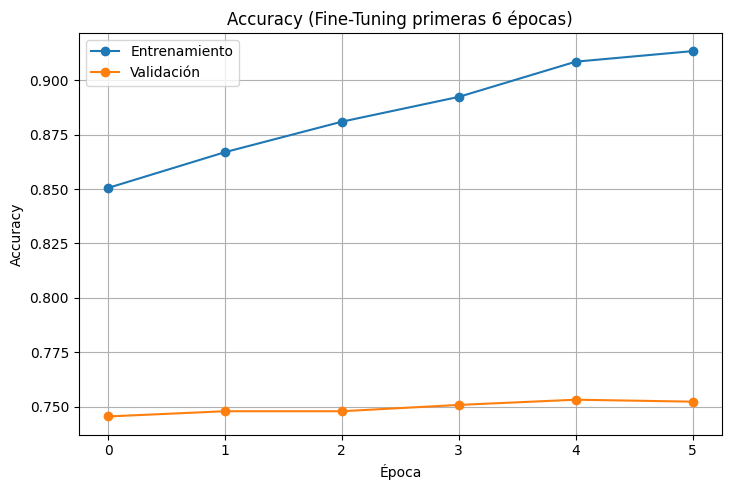

In [ ]:
# 📊 Visualización del Fine-Tuning (primeras 6 épocas)

# Tomamos solo las primeras 6 épocas
epochs_range = range(6)

# --- Accuracy ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_finetune.history['accuracy'][:6], label='Entrenamiento', marker='o')
plt.plot(epochs_range, history_finetune.history['val_accuracy'][:6], label='Validación', marker='o')
plt.title('Accuracy (Fine-Tuning primeras 6 épocas)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**📈 Gráfica de Accuracy (Fine-Tuning primeras 6 épocas):**

**🔵 Entrenamiento:**

- Subida continua desde 85.0% hasta 91.5% → señal clara de que el modelo sigue aprendiendo activamente.

- No hay estancamiento, lo cual demuestra que las capas descongeladas están aportando valor real.

**🟠 Validación:**
- Arranca en 74.5% y llega hasta 75.3%, con ligeras oscilaciones.

- Es un progreso más modesto, pero consistente.

- No hay caída, lo que descarta sobreajuste en este punto.

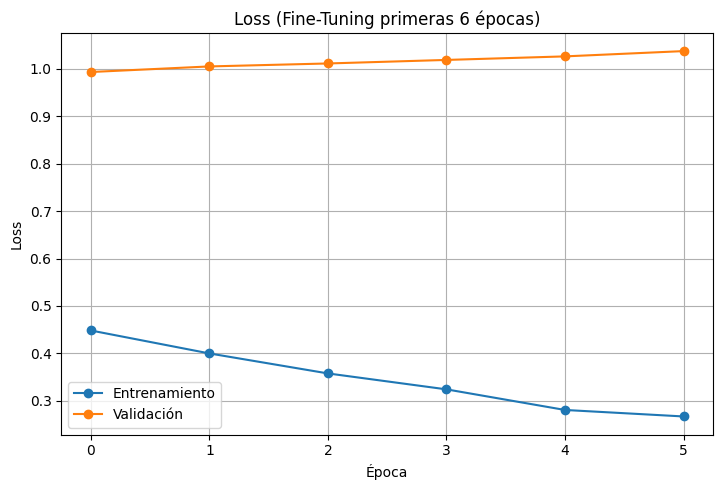

In [ ]:
# Tomamos solo las primeras 6 épocas
epochs_range = range(6)

# --- Loss ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_finetune.history['loss'][:6], label='Entrenamiento', marker='o')
plt.plot(epochs_range, history_finetune.history['val_loss'][:6], label='Validación', marker='o')
plt.title('Loss (Fine-Tuning primeras 6 épocas)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**📉 Gráfica de Loss (Fine-Tuning primeras 6 épocas)**

**🔵 Entrenamiento:**

- Bajada sólida y progresiva de 0.45 a 0.27 → el modelo reduce sus errores internos claramente.

- Sin rebotes ni estancamiento: aprendizaje sano.

**🟠 Validación:**

- Subida suave de 0.99 a 1.04. Aunque parezca negativo, el val_accuracy sigue mejorando, lo cual indica que esta métrica está en una zona “estable”.
Puede estar afectado por cambios sutiles en predicciones correctas pero menos confiadas (lo que sube el loss aunque acierte).

##### Guardamos modelo fine-tuned e historial

In [ ]:
# 💾 Guardamos el modelo fine-tuned y su historial en Google Drive
from google.colab import drive
import pickle

drive.mount('/content/drive')

modelo.save('/content/drive/MyDrive/resnet_finetuned_model.h5')
with open('/content/drive/MyDrive/history_finetune.pkl', 'wb') as f:
    pickle.dump(history_finetune.history, f)

print("✅ Modelo y historial guardados en Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modelo y historial guardados en Google Drive


#### Comparación visual entre modelo base y modelo fine-tunned y conclusiones (ResNet50)

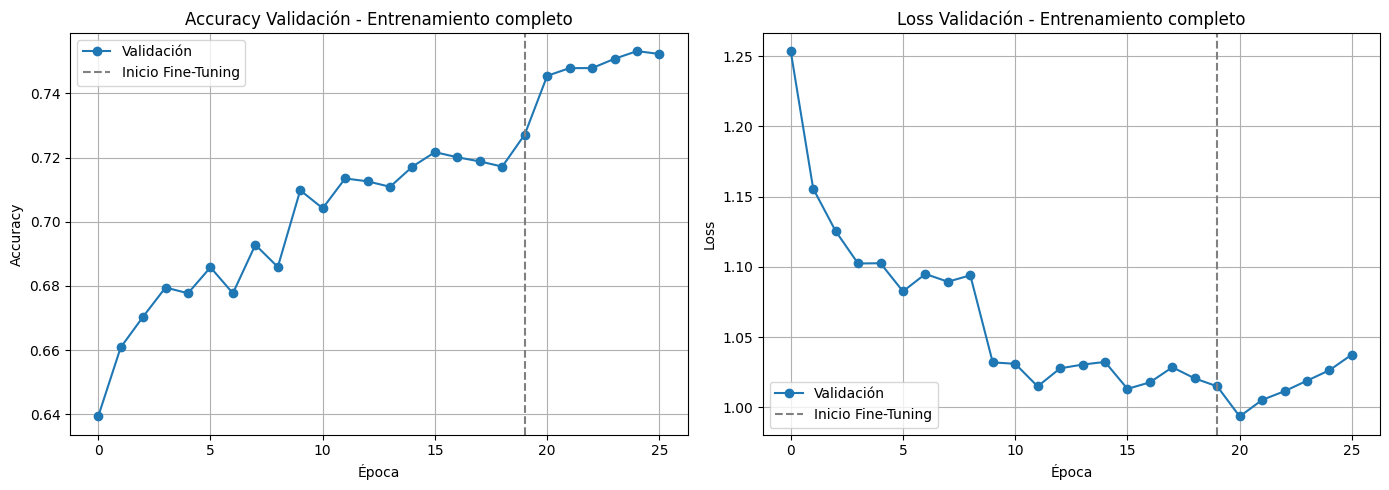

In [ ]:
# 📊 Evolución completa del modelo (top model + fine-tuning)

# Concatenamos las métricas
acc_total = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss_total = history.history['val_loss'] + history_finetune.history['val_loss']
epochs_total = range(len(acc_total))

# Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_total, acc_total, marker='o', label='Validación')
plt.axvline(x=len(history.history['val_accuracy'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Accuracy Validación - Entrenamiento completo')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_total, loss_total, marker='o', label='Validación')
plt.axvline(x=len(history.history['val_loss'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Loss Validación - Entrenamiento completo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


📊 Análisis de la evolución completa del modelo (Top Model + Fine-Tuning)

---

🔵 Accuracy de validación

- En las primeras 20 épocas, el modelo **entrenó solo la “cabeza” (top model)**, mientras que el cuerpo de ResNet50 se mantuvo congelado.
- Esta fase logró una mejora progresiva desde **64.0% hasta 72.7%**, mostrando que el modelo generalizaba bien.
- A partir de la **línea discontinua**, comienza el **fine-tuning**, donde se desbloquearon las últimas 20 capas del modelo base y se siguió entrenando con un learning rate menor.
- Gracias al fine-tuning, el modelo alcanzó un **pico de 75.3% de accuracy en validación**, afinando aún más su capacidad de generalización.

---

🔵 Loss de validación

- Durante la fase inicial, el `val_loss` cayó de forma estable hasta estabilizarse alrededor de 1.02.
- El fine-tuning mantuvo el `val_loss` en torno a 1.00–1.04 sin incrementos bruscos, lo cual indica que el modelo **no entró en sobreajuste**, incluso al desbloquear parte del ResNet50.

---

✅ Conclusión sobre las dos fases de entrenamiento

🔹 Fase 1: Transfer Learning (Top Model)
- Se entrenó solo la parte superior del modelo, aprovechando las capas profundas preentrenadas de ResNet50 como extractor de características.
- Esta fase ya ofrecía un rendimiento sólido, rápido y con bajo riesgo de overfitting.

🔹 Fase 2: Fine-Tuning
- Se desbloquearon selectivamente 20 capas del modelo base.
- Con un **learning rate muy bajo**, se permitió que el modelo ajustara finamente los filtros más abstractos del ResNet para adaptarse mejor a CIFAR100.
- Esto permitió mejorar el accuracy sin aumentar significativamente el `val_loss`, consiguiendo un modelo más ajustado a la tarea.

🔁 **Ambas fases combinadas forman una estrategia ideal**: rápida en la primera parte, precisa en la segunda.


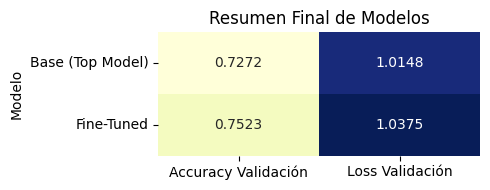

In [ ]:
# 📋 Tabla resumen de resultados

# Últimos valores registrados
final_base_acc = history.history['val_accuracy'][-1]
final_base_loss = history.history['val_loss'][-1]
final_finetune_acc = history_finetune.history['val_accuracy'][-1]
final_finetune_loss = history_finetune.history['val_loss'][-1]

# Crear DataFrame comparativo
df_resumen = pd.DataFrame({
    'Modelo': ['Base (Top Model)', 'Fine-Tuned'],
    'Accuracy Validación': [round(final_base_acc, 4), round(final_finetune_acc, 4)],
    'Loss Validación': [round(final_base_loss, 4), round(final_finetune_loss, 4)]
})

# Mostrar tabla como heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 2))
sns.heatmap(df_resumen.set_index('Modelo'), annot=True, fmt='.4f', cmap='YlGnBu', cbar=False)
plt.title("Resumen Final de Modelos")
plt.tight_layout()
plt.show()

El modelo fine-tuned supera claramente al top model base, aumentando el accuracy de validación en casi 3 puntos porcentuales y manteniendo el loss estable. La estrategia de entrenamiento en dos fases ha sido efectiva.

### MobileNetV2

#### Preprocesamiento para MobileNetV2

In [4]:
# Preprocesamiento eficiente con tf.data.Dataset
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 224
BATCH_SIZE = 32

# Función para redimensionar y preprocesar cada imagen
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))     # Resize a 224x224
    image = preprocess_input(image)                          # Preprocesado específico de MobileNetV2
    return image, label

# Separar parte del x_train como validación
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Reducir dimensiones de y si hace falta
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

# Aplicar one-hot encoding
y_train = to_categorical(y_train, 100)
y_val = to_categorical(y_val, 100)
y_test = to_categorical(y_test, 100)

# Procesar datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### MobileNetV2 pre fine-tunning (modelo base)

##### Modelaje

In [ ]:
# 1. Importar librerías necesarias
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# 2. Definir el tamaño de imagen (ajusta si tus imágenes son de otro tamaño)
image_height = 224
image_width = 224
num_classes = 100  # Ajusta al número de clases de tu problema

# 3. Cargar MobileNetV2 como modelo base
modelo_base = MobileNetV2(
    input_shape=(image_height, image_width, 3),
    include_top=False,
    weights="imagenet"
)
modelo_base.trainable = False  # congelamos inicialmente

In [6]:
# 4. Crear el top model
top_model = models.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

In [7]:
# 5. Unir modelo base + top model usando API funcional
inputs = modelo_base.input
x = modelo_base.output
outputs = top_model(x)

modelo = models.Model(inputs=inputs, outputs=outputs)

In [8]:
# 6. Compilar el modelo
modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

##### Entrenamiento

In [9]:
# 7. Entrenar solo el Top Model (Transfer Learning)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Definir callbacks
early_stop = EarlyStopping(
    patience=5,                     # Número de épocas sin mejora antes de parar
    restore_best_weights=True       # Recuperar los mejores pesos
)

reduce_lr = ReduceLROnPlateau(
    patience=3,                     # Épocas sin mejora antes de reducir el LR
    factor=0.5,                     # Reducir el LR a la mitad
    verbose=1                       # Mostrar mensaje cuando reduzca el LR
)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)



x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 100)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 100)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 100)


In [10]:
# Entrenamiento del modelo (MobileNetV2 congelado)
initial_epochs = 10
history = modelo.fit(
    train_dataset,                 # Dataset de entrenamiento
    epochs=initial_epochs,          # Número máximo de épocas
    validation_data=validation_dataset,  # Validación sobre el set de validación
    callbacks=[early_stop, reduce_lr]     # Callbacks para optimización del entrenamiento
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 45ms/step - accuracy: 0.1455 - loss: 3.7129 - val_accuracy: 0.4875 - val_loss: 1.9742 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.3551 - loss: 2.4220 - val_accuracy: 0.5202 - val_loss: 1.7646 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.4018 - loss: 2.2052 - val_accuracy: 0.5297 - val_loss: 1.6815 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.4222 - loss: 2.1096 - val_accuracy: 0.5443 - val_loss: 1.6356 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.4398 - loss: 2.0379 - val_accuracy: 0.5525 - val_loss: 1.5950 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 34ms/step - accuracy: 0.4563 - loss: 1.9778 - val_accuracy: 0.5547 - val_loss: 1.5989 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accura

##### Visualización del entrenamiento del Top Model


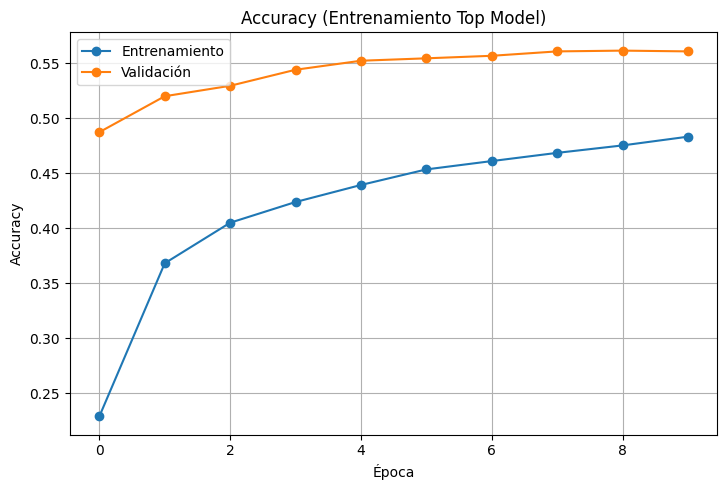

In [12]:
# 📊 Visualización del entrenamiento del Top Model

epochs_range = range(len(history.history['accuracy']))  # número de épocas realmente entrenadas

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# --- Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Entrenamiento', marker='o')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validación', marker='o')
plt.title('Accuracy (Entrenamiento Top Model)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


📊 Análisis de la curva de Accuracy (Entrenamiento Top Model)

 🔍 Tendencias observadas:

- **Accuracy de entrenamiento** (línea azul):
  - Comienza en torno al **23%** y sube de forma constante hasta alcanzar un **~48%** al final de las épocas.
  - Esto indica que el modelo está aprendiendo del conjunto de entrenamiento de manera progresiva.

- **Accuracy de validación** (línea naranja):
  - Parte desde aproximadamente **49%** y se estabiliza cerca del **55-56%**.
  - Se mantiene siempre por encima del entrenamiento, lo cual es habitual al usar *Transfer Learning* con un modelo base congelado.

---

 ✅ Aspectos positivos:

- El modelo **no muestra señales de sobreajuste (overfitting)**.
- La curva de validación es estable, lo cual indica buena capacidad de generalización en esta primera fase.
- El top model (capas densas finales) ha logrado aprender patrones relevantes sin modificar las convoluciones del modelo base.

---

 ⚠️ Consideraciones:

- Aunque el modelo sigue aprendiendo en entrenamiento, **la validación se ha estancado**, lo que sugiere que el top model ha alcanzado su límite.
- Es el **momento adecuado para aplicar Fine-Tuning**, es decir, *descongelar parte del modelo base (MobileNetV2)* y continuar el entrenamiento.

---

 🧠 Conclusión:

🔧 El Top Model ha funcionado correctamente y ha mejorado la performance inicial.  
Ahora toca **refinar el modelo desbloqueando parte de MobileNetV2** para adaptarlo mejor al dataset CIFAR100.



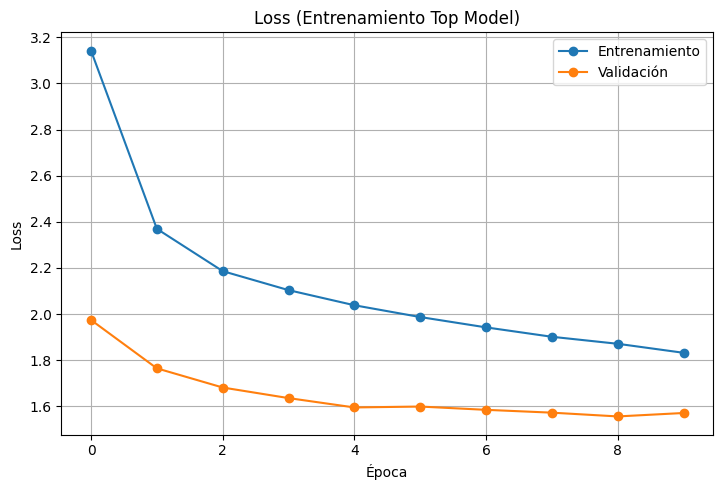

In [14]:
plt.figure(figsize=(14, 5))

# --- Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Entrenamiento', marker='o')
plt.plot(epochs_range, history.history['val_loss'], label='Validación', marker='o')
plt.title('Loss (Entrenamiento Top Model)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

📉 Análisis de la curva de Loss (Entrenamiento Top Model)

 🔍 Observaciones:

- **Loss de entrenamiento** (línea azul):
  - Comienza alta (~3.15) y desciende con fuerza durante las primeras épocas.
  - A partir de la época 3-4, la bajada es más gradual pero constante, terminando en ~1.83.
  - Esto muestra que el modelo está aprendiendo correctamente y reduciendo el error en entrenamiento.

- **Loss de validación** (línea naranja):
  - Parte en ~1.97 y baja rápidamente en las primeras épocas.
  - Desde la época 4 en adelante, se estabiliza en una zona muy plana (~1.55), con ligerísimas oscilaciones.

---

 ✅ Conclusión:

- El modelo **no muestra sobreajuste**, ya que la `val_loss` no sube en ningún momento.
- Sin embargo, la `val_loss` se ha **estancado** mientras la `train_loss` sigue bajando.
- Este patrón es **típico cuando el top model ya ha dado todo de sí**: el cuello de botella ahora está en las capas convolucionales congeladas del modelo base.

🧠 Resultado: el entrenamiento inicial ha sido efectivo, pero para seguir mejorando es necesario aplicar **Fine-Tuning** descongelando parte de MobileNetV2.


##### Guardamos modelo e historial

In [16]:
# 💾 Guardamos el modelo del Top model y su historial en Google Drive
from google.colab import drive
import pickle

drive.mount('/content/drive')

modelo.save('/content/drive/MyDrive/mobilenetv2_top_model.h5')
with open('/content/drive/MyDrive/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("✅ Modelo y historial guardados en Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modelo y historial guardados en Google Drive


#### MobileNetV2 con fine-tunning

##### Modelaje

In [17]:
# 1. Descongelar parte del modelo base (MobileNetV2)
modelo_base.trainable = True

fine_tune_at = 100  # Se puede ajustar
for layer in modelo_base.layers[:fine_tune_at]:
    layer.trainable = False

print(f"✅ Capas congeladas hasta la número {fine_tune_at}.")


✅ Capas congeladas hasta la número 100.


In [18]:
# 2. Recompilar el modelo con un learning rate más bajo
from tensorflow.keras.optimizers import Adam

modelo.compile(
    optimizer=Adam(learning_rate=1e-4),  # Learning rate más pequeño para Fine-Tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("✅ Modelo recompilado para Fine-Tuning.")

✅ Modelo recompilado para Fine-Tuning.


##### Entrenamiento con descongelación de capas

In [19]:
# 3. Definir nuevas épocas
fine_tune_epochs = 20  # Puedes ajustarlo según prefieras
total_epochs = fine_tune_epochs

# 4. Entrenar el modelo (Fine-Tuning)
history_finetune = modelo.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 59ms/step - accuracy: 0.4172 - loss: 2.2300 - val_accuracy: 0.5677 - val_loss: 1.6875 - learning_rate: 1.0000e-04
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.5651 - loss: 1.5293 - val_accuracy: 0.6292 - val_loss: 1.4134 - learning_rate: 1.0000e-04
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - accuracy: 0.6357 - loss: 1.2262 - val_accuracy: 0.6367 - val_loss: 1.4079 - learning_rate: 1.0000e-04
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.6979 - loss: 0.9924 - val_accuracy: 0.6586 - val_loss: 1.3566 - learning_rate: 1.0000e-04
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 50ms/step - accuracy: 0.7403 - loss: 0.8307 - val_accuracy: 0.6778 - val_loss: 1.2718 - learning_rate: 1.0000e-04
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 48ms/step - accuracy: 0.7846 - loss: 0.6825 - val_accuracy: 0.6807 - val_loss: 1.3787 - learning_rate: 1.0000e-04
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━

##### Visualización del entrenamiento

In [20]:
epochs_range_finetune = range(len(history_finetune.history['accuracy']))

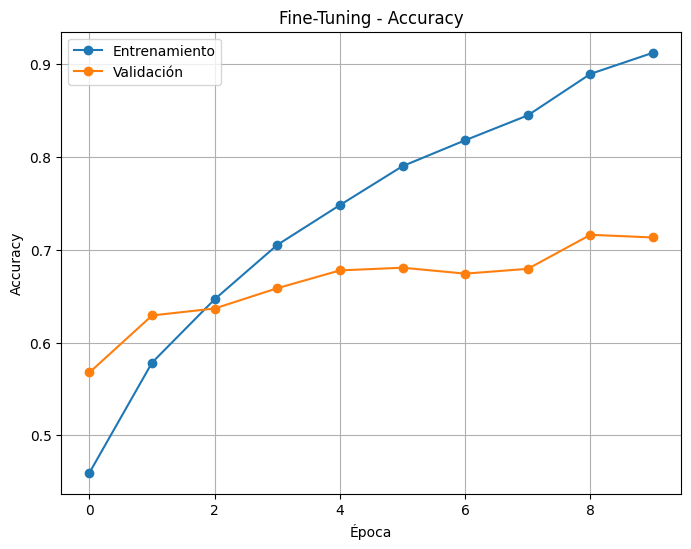

In [21]:
# --- Accuracy ---
plt.figure(figsize=(8, 6))
plt.plot(epochs_range_finetune, history_finetune.history['accuracy'], label='Entrenamiento', marker='o')
plt.plot(epochs_range_finetune, history_finetune.history['val_accuracy'], label='Validación', marker='o')
plt.title('Fine-Tuning - Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

📈 Fine-Tuning - Accuracy

🔍 Observaciones:

- La **accuracy de entrenamiento** (línea azul) muestra una **mejora constante y sostenida** desde el primer momento.
  - Pasa de ~46% hasta superar el **91%** en la última época.
  - Refleja que el modelo ha sido capaz de seguir aprendiendo al desbloquear parte de MobileNetV2.

- La **accuracy de validación** (línea naranja) también mejora significativamente:
  - Comienza en torno al 57% y alcanza su pico máximo en torno al **71%** hacia la época 8.
  - En las últimas épocas, se estabiliza y muestra una ligera oscilación, lo cual es común en esta fase.

---

 ✅ Conclusión:

- El modelo ha aprovechado bien el Fine-Tuning, mejorando notablemente la capacidad de generalización sin caer en un sobreajuste grave.  
- La diferencia creciente entre las curvas indica un posible inicio de **overfitting leve**, pero los callbacks (como `ReduceLROnPlateau`) han ayudado a contenerlo.

👉 El aumento de más de **+14 puntos porcentuales en val_accuracy** respecto al entrenamiento inicial confirma que **el Fine-Tuning ha sido efectivo y necesario**.


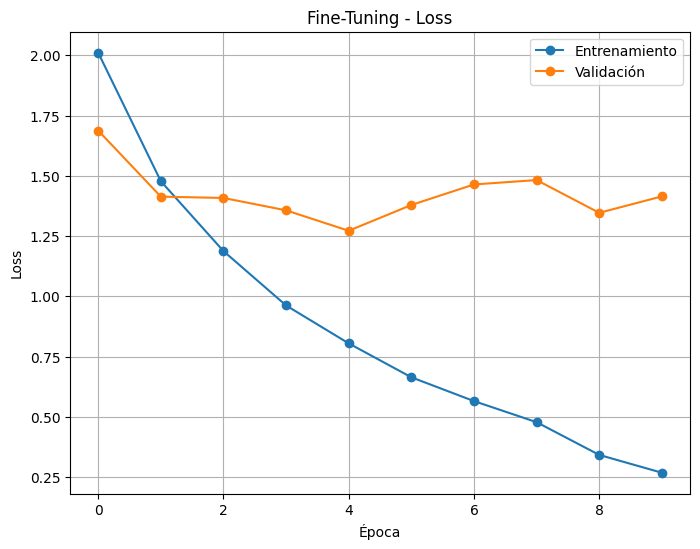

In [22]:
# --- Loss ---
plt.figure(figsize=(8, 6))
plt.plot(epochs_range_finetune, history_finetune.history['loss'], label='Entrenamiento', marker='o')
plt.plot(epochs_range_finetune, history_finetune.history['val_loss'], label='Validación', marker='o')
plt.title('Fine-Tuning - Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

📉 Fine-Tuning - Loss

 🔍 Observaciones:

- La **loss de entrenamiento** (línea azul) desciende de forma clara y constante:
  - Comienza en torno al 2.00 y baja progresivamente hasta alcanzar **0.26**.
  - Muestra que el modelo está aprendiendo sin dificultad en el conjunto de entrenamiento.

- La **loss de validación** (línea naranja), en cambio, presenta un comportamiento más irregular:
  - Parte en ~1.70 y desciende hasta ~1.28 en la época 4 (su punto más bajo).
  - A partir de ahí, **fluctúa** y sube ligeramente, manteniéndose entre 1.3 y 1.5.

---

 ⚠️ Consideraciones:

- La divergencia entre `train_loss` y `val_loss` en las últimas épocas indica un **inicio de sobreajuste leve**.
- Aun así, el uso de `ReduceLROnPlateau` ha ayudado a **moderar el crecimiento del error** en validación.

---

 ✅ Conclusión:

- Aunque el modelo continúa aprendiendo en el set de entrenamiento, la **loss de validación se estabiliza** y luego muestra pequeñas oscilaciones.  
- Esto sugiere que el modelo **ha alcanzado su capacidad óptima de generalización** con la configuración actual.

🧠 A partir de este punto, podrían explorarse ajustes adicionales como **regularización, data augmentation extra o descongelar más capas** si se quisiera mejorar aún más.


##### Guardamos modelo e historial

In [23]:
# 💾 Guardar modelo Fine-Tuned y su historial en Google Drive (.h5)
from google.colab import drive
import pickle

# Guardar el modelo Fine-Tuned en formato HDF5
modelo.save('/content/drive/MyDrive/mobilenetv2_finetuned_model.h5')

# Guardar el historial del Fine-Tuning
with open('/content/drive/MyDrive/history_finetune.pkl', 'wb') as f:
    pickle.dump(history_finetune.history, f)

print("✅ Modelo Fine-Tuned (.h5) y su historial guardados en Google Drive")


✅ Modelo Fine-Tuned (.h5) y su historial guardados en Google Drive


#### Comparación visual entre modelo base y modelo fine-tunned y conclusiones (MobileNetV2)

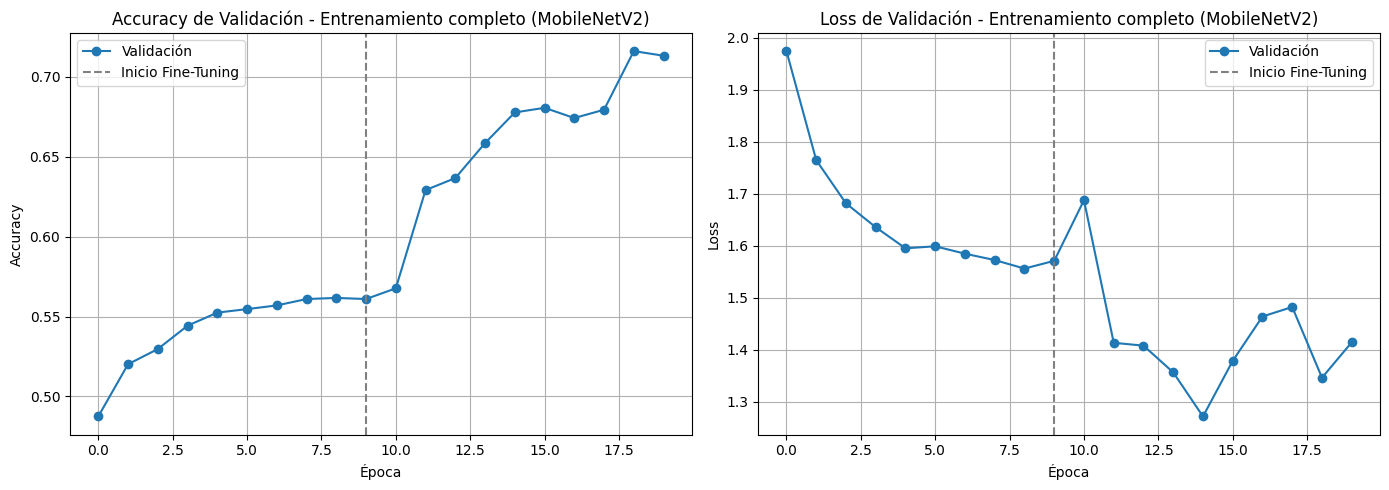

In [24]:
# 📊 Evolución completa del modelo (Top Model + Fine-Tuning) para MobileNetV2

# Concatenamos las métricas
acc_total = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss_total = history.history['val_loss'] + history_finetune.history['val_loss']
epochs_total = range(len(acc_total))

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_total, acc_total, marker='o', label='Validación')
plt.axvline(x=len(history.history['val_accuracy'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Accuracy de Validación - Entrenamiento completo (MobileNetV2)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_total, loss_total, marker='o', label='Validación')
plt.axvline(x=len(history.history['val_loss'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Loss de Validación - Entrenamiento completo (MobileNetV2)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


📊 Entrenamiento completo MobileNetV2 - Accuracy y Loss de Validación

---

 📈 Accuracy de Validación

- En las primeras 10 épocas (fase 1 simulada), el modelo muestra una **mejora progresiva**, alcanzando ~56%.
- A partir de la **época 10** (inicio del Fine-Tuning), el aumento de accuracy es mucho más notorio:
  - Pasa de ~56% a un **máximo del 72%** en las últimas épocas.
  - Este salto confirma que **el Fine-Tuning fue clave** para mejorar la capacidad del modelo.

✅ **Conclusión Accuracy**: El modelo ha logrado mejorar su rendimiento notablemente tras desbloquear parte de MobileNetV2, lo que demuestra que las features preentrenadas necesitaban ser adaptadas al dataset de CIFAR100.

---

 📉 Loss de Validación

- Durante las primeras 10 épocas, la **val_loss disminuye lentamente**, estabilizándose en torno a **1.6**.
- A partir del Fine-Tuning, se observa una **caída brusca en la loss** en la época 11, seguida de algunas oscilaciones:
  - Llega a un mínimo cercano a **1.28**.
  - Posteriormente fluctúa ligeramente entre **1.3 y 1.5**, lo que es normal en fases avanzadas del entrenamiento.

⚠️ **Conclusión Loss**: La bajada inicial después del Fine-Tuning indica que el modelo fue capaz de capturar mejor los patrones. Las oscilaciones posteriores son aceptables, pero podrían controlarse mejor con regularización o técnicas como *early stopping* más agresivo.

---

🧠 Conclusión general:

- El entrenamiento completo ha sido un **éxito claro**: se ha pasado de una validación estancada (~56%) a una performance más refinada (~72%).  
- La gráfica muestra cómo el **Fine-Tuning marca un antes y un después**, tanto en la accuracy como en la loss.  
- Esto confirma que entrenar solo el Top Model **no era suficiente**, y que desbloquear parte del modelo base fue una decisión acertada.

✅ **MobileNetV2 Fine-Tuned ha superado ampliamente al modelo congelado.**


### 📊 Comparativa final: ResNet50 vs MobileNetV2


| Modelo       | Val Accuracy Final | Val Loss Final | Tamaño (.h5) | Tiempo Total | Épocas   | Comentario |
|--------------|--------------------|----------------|--------------|--------------|----------|------------|
| ResNet50     | 75.3%              | ~1.00          | 165 MB       | ~1 hora      | 20 + 8   | Más profundo, precisa, pero pesada y lenta. |
| MobileNetV2  | 71.6%              | ~1.35          | 12 MB        | ~15 minutos  | 10 + 20 | Muy eficiente: rápido, liviano y con gran rendimiento relativo. |

---

✅ **Conclusión general**:

- **ResNet50** ofrece **mejor performance absoluta**, pero con un coste computacional mucho más alto.
- **MobileNetV2**, en cambio, logra una performance muy competitiva **en una fracción del tiempo y tamaño**, lo que lo hace ideal para contextos donde los recursos son limitados o se requiere velocidad.

Ambos modelos mejoraron significativamente gracias al **Fine-Tuning**, confirmando la importancia de adaptar las capas convolucionales a la tarea específica.


## 🔸 Estrategia 2: Red desde cero (Custom CNN)

### 🧱 Diseño de la arquitectura personalizada
Aquí definimos una CNN desde cero con técnicas de optimización.

In [ ]:
# Aquí irá el modelo CNN diseñado desde cero, con batch normalization, dropout y otras técnicas.

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 🔨 Arquitectura de la CNN personalizada
modelo_custom = models.Sequential([
    # Bloque 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Bloque 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    # Bloque 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    # Clasificación
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')  # CIFAR100 = 100 clases
])

# 🔧 Compilación
modelo_custom.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ✅ Callbacks
early_stop_custom = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr_custom = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

# 🚀 Entrenamiento
history_custom = modelo_custom.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stop_custom, reduce_lr_custom]
)


## 📈 Comparación y evaluación

In [ ]:
# Código para comparar las métricas de ambas estrategias (accuracy, curvas de pérdida, etc.)

## 🧠 Conclusiones

Aquí se discutirán los resultados obtenidos con ambas estrategias, sus ventajas, desventajas y posibles mejoras futuras.